# Setup tests for EveryBeam MWA by comparing to hyperdrive

First up, here are all the module loads you need to do. Define some constants as well while we're at it

In [1]:
from astropy.io import fits
import numpy as np
from astropy.wcs import WCS
from copy import deepcopy
import erfa
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import mwa_hyperbeam
from subprocess import call
import everybeam as eb
from casacore.tables import table
import numpy as np

print(mwa_hyperbeam.__version__)

D2R = np.pi / 180.0
VELC = 299792458.0
MWA_LAT = -26.703319405555554
MWA_LAT_RAD = MWA_LAT * D2R
MWA_LONG = 116.67081523611111
MWA_HEIGHT = 377.83

NSIDE=31

zenith_delays = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

freqs = [100e+6, 150e+6, 200e+6]

0.10.1


## Look at the mesaurement set
First up, let's look at the `MWA-single-timeslot.ms"` measurement set, which we'll use as input to EveryBeam. We'll poke around a bit to see what's in there.

In [2]:
mwa_ms_path = "../../../test_installation/everybeam/MWA-single-timeslot.ms"

##Tells you the names of all the columns at the top level of the MS
with table(mwa_ms_path) as mwa_ms:
    colnames = mwa_ms.colnames()
    subtables = mwa_ms.getsubtables()
    
    print('COLNAMES:')
    for colname in colnames:
        print(colname)
        
    print('SUBTABLES:')
    for subtable in subtables:
        print(subtable)

Successful readonly open of default-locked table ../../../test_installation/everybeam/MWA-single-timeslot.ms: 24 columns, 2628 rows
COLNAMES:
UVW
FLAG_CATEGORY
WEIGHT
SIGMA
ANTENNA1
ANTENNA2
ARRAY_ID
DATA_DESC_ID
EXPOSURE
FEED1
FEED2
FIELD_ID
FLAG_ROW
INTERVAL
OBSERVATION_ID
PROCESSOR_ID
SCAN_NUMBER
STATE_ID
TIME
TIME_CENTROID
DATA
FLAG
LOFAR_FULL_RES_FLAG
WEIGHT_SPECTRUM
SUBTABLES:
/home/jack-line/software/WODEN_dev/test_installation/everybeam/MWA-single-timeslot.ms/ANTENNA
/home/jack-line/software/WODEN_dev/test_installation/everybeam/MWA-single-timeslot.ms/DATA_DESCRIPTION
/home/jack-line/software/WODEN_dev/test_installation/everybeam/MWA-single-timeslot.ms/FEED
/home/jack-line/software/WODEN_dev/test_installation/everybeam/MWA-single-timeslot.ms/FLAG_CMD
/home/jack-line/software/WODEN_dev/test_installation/everybeam/MWA-single-timeslot.ms/FIELD
/home/jack-line/software/WODEN_dev/test_installation/everybeam/MWA-single-timeslot.ms/HISTORY
/home/jack-line/software/WODEN_dev/test_insta

OK, so there is a bunch of stuff in there. We care about the `MWA_TILE_POINTING` subtable which tells us about the MWA beam settings:

In [3]:
##I think the FIELD table is the one that tells you the pointing direction of the observation
##Delay dir seems to be pointing?
with table(mwa_ms_path + "::FIELD") as field_subtable:
    delay_dir = field_subtable.getcol('DELAY_DIR')
    print(f"This file is phased to RA, Dec {np.degrees(np.squeeze(delay_dir))}?" )

with table(mwa_ms_path + "::MWA_TILE_POINTING") as mwa_tile_subtable:
    print(mwa_tile_subtable.colnames())
    print("MWA_TILE_POINTING::INTERVAL", mwa_tile_subtable.getcol('INTERVAL'))
    print("MWA_TILE_POINTING::DELAYS", mwa_tile_subtable.getcol('DELAYS'))
    print("MWA_TILE_POINTING::DIRECTION", mwa_tile_subtable.getcol('DIRECTION'))

Successful readonly open of default-locked table ../../../test_installation/everybeam/MWA-single-timeslot.ms::FIELD: 10 columns, 1 rows
This file is phased to RA, Dec [124.999995 -42.75    ]?
Successful readonly open of default-locked table ../../../test_installation/everybeam/MWA-single-timeslot.ms::MWA_TILE_POINTING: 3 columns, 1 rows
['INTERVAL', 'DELAYS', 'DIRECTION']
MWA_TILE_POINTING::INTERVAL [[4.87541808e+09 4.87541819e+09]]
MWA_TILE_POINTING::DELAYS [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
MWA_TILE_POINTING::DIRECTION [[0. 0.]]


So overall this is a zenith pointing, and I assume `DIRECTION` is in zenith angle, azimuth angle.

What about the date and LST? We want to test using two times, and might as well make them a couple of hours apart to check the beam stays locked to observer's position.

In [4]:
from astropy.time import Time, TimeDelta
import astropy.units as u
from astropy.coordinates import EarthLocation


with table(mwa_ms_path) as mwa_ms:
    time_col = mwa_ms.getcol("TIME")
    first_time = time_col[0]
    
date = Time(first_time*u.s, format='mjd')
first_date = date.datetime.strftime('%Y-%m-%dT%H:%M:%S')
print(first_date, date.mjd*24*3600)
observing_location = EarthLocation(lat=MWA_LAT*u.deg, lon=MWA_LONG*u.deg, height=MWA_HEIGHT)


time_inc = 3*3600

times = [Time(date, scale='utc', location=observing_location) + TimeDelta(time_inc*i, format='sec') for i in range(2)]

lsts = [time.sidereal_time('mean').rad for time in times]

print(np.degrees(lsts))


Successful readonly open of default-locked table ../../../test_installation/everybeam/MWA-single-timeslot.ms: 24 columns, 2628 rows
2013-05-16T10:48:48 4875418128.999999
[153.1889998  198.31220514]


## Make some sky coords

First up, make some ra, dec coords that cover most of the sky. We want to test two time steps, so calculate two sets of az, za coords.
Save the az/za to a C-style header as `call_everybeam.cc::run_mwa_beam` takes az/za as input. We'll also need the parallactic angle for `run_mwa_beam`.

1.629861474015283 -0.827400760331735 -0.4660608448386394 1.9379283806549448
2.4174099763296204 -0.827400760331735 -0.4660608448386394 2.502682148182243
(1922,) 1922


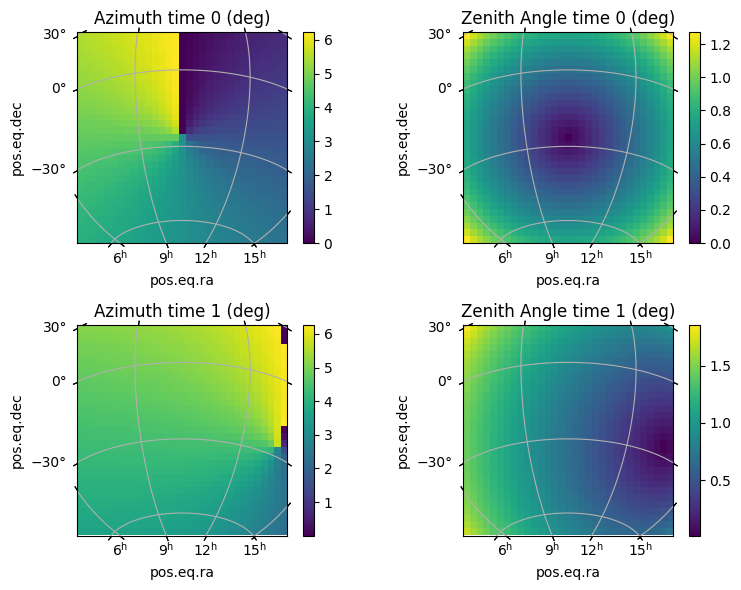

In [5]:
MWA_LAT = -26.703319405555554

##Setup a dummy FITS header with appropriate settings
header = fits.Header()

##Give it 301 pixel for each axis
nside = NSIDE

##This resolution seems to cover the full sky nicely
cpix = int(nside // 2) + 1
cdelt = 0.35
cdelt = 80 / nside

header['NAXIS']   = 2
header['NAXIS1']  = nside
header['NAXIS2']  = nside
header['CTYPE1']  = 'RA---SIN'
header['CRPIX1']  = cpix
header['CRVAL1']  = np.degrees(lsts[0])
header['CDELT1']  = cdelt
header['CUNIT1']  = 'deg     '
header['CTYPE2']  = 'DEC--SIN'
header['CRPIX2']  = cpix
header['CRVAL2']  = MWA_LAT
header['CDELT2']  = cdelt
header['CUNIT2']  = 'deg     '

##Make a world coord system
wcs = WCS(header)

##Set up x/y pixels that cover the whole image
x_mesh, y_mesh = np.meshgrid(np.arange(nside), np.arange(nside))

x_pixels = x_mesh.flatten()
y_pixels = y_mesh.flatten()

##convert to ra, dec
ras, decs = wcs.all_pix2world(x_pixels, y_pixels, 0.0)

def convert_to_azza_para(lst_deg):
    
    ##Then use erfa to convert these values into azs, els
    has = lst_deg - ras

    ##use this erfa function to convert to azimuth and elevation
    ##were using degrees, but erfa uses rads, so convert here
    azs, els = erfa.hd2ae(np.radians(has), np.radians(decs), np.radians(MWA_LAT))
    
    para_angles = erfa.hd2pa(np.radians(has), np.radians(decs), np.radians(MWA_LAT))

    ##convert elevation to zenith angle
    zas = np.pi/2 - els
    
    print(np.radians(has[0]), np.radians(decs[0]), MWA_LAT_RAD, para_angles[0])

    # ##Mask below horizon for better plots
    # below_horizon = np.where(zas > np.pi/2)
    # azs[below_horizon] = np.nan
    # zas[below_horizon] = np.nan
    # para_angles[below_horizon] = np.nan

    return azs, zas, para_angles

az_flat_time0, za_flat_time0, para_angles_time0 = convert_to_azza_para(np.degrees(lsts[0]))
az_flat_time1, za_flat_time1, para_angles_time1 = convert_to_azza_para(np.degrees(lsts[1]))

fig, axs = plt.subplots(2,2, figsize=(8,6), subplot_kw={'projection':wcs})

arr_plots = [az_flat_time0, za_flat_time0, az_flat_time1, za_flat_time1]
labels = ['Azimuth time 0 (deg)', 'Zenith Angle time 0 (deg)',
          'Azimuth time 1 (deg)', 'Zenith Angle time 1 (deg)',]

for arr, ax, label in zip(arr_plots, axs.flatten(),labels):
    arr.shape = (nside,nside)
    im = ax.imshow(arr,origin='lower')
    arr.shape = nside*nside
    ax.grid()
    ax.set_title(label)
    
    plt.colorbar(im, ax=ax)

plt.tight_layout()

az_flat = np.concatenate([az_flat_time0, az_flat_time1])
za_flat = np.concatenate([za_flat_time0, za_flat_time1])
para_flat = np.concatenate([para_angles_time0, para_angles_time1])

print(az_flat.shape, len(az_flat))


with open('azza_para_nside{:03d}.h'.format(nside),'w') as outfile:

    az_arr = 'user_precision_t nside{:03d}_azs[] = {{'.format(nside)
    za_arr = 'user_precision_t nside{:03d}_zas[] = {{'.format(nside)
    para_arr = 'user_precision_t nside{:03d}_paras[] = {{'.format(nside)

    for coord in range(len(az_flat)-1):
        az_arr += '{:.7f},'.format(az_flat[coord])
        za_arr += '{:.7f},'.format(za_flat[coord])
        para_arr += '{:.7f},'.format(para_flat[coord])

    az_arr += '{:.7f}}};\n'.format(az_flat[-1])
    za_arr += '{:.7f}}};\n'.format(za_flat[-1])
    para_arr += '{:.7f}}};\n'.format(para_flat[-1])

    outfile.write(az_arr)
    outfile.write(za_arr)
    outfile.write(para_arr)

## Make `hyperbeam` outputs with python to test against
This loops through three frequencies and three pointings, runs `hyperbeam`, and writes out text files of the results.

In [6]:
from os import environ


filepath="/home/jack-line/software/mwa_beam_files/mwa_full_embedded_element_pattern.h5"
# filepath=environ['MWA_FEE_HDF5']

beam = mwa_hyperbeam.FEEBeam(hdf5_file=filepath)

gains = [1]*16

freqs = [100e+6, 150e+6, 200e+6]

norm_to_zenith = True
iau_order = True

hyper_jones_100_time0 = beam.calc_jones_array(az_flat_time0, za_flat_time0, 100e+6,
                                        zenith_delays, gains, norm_to_zenith,
                                        MWA_LAT_RAD, iau_order)

hyper_jones_150_time0 = beam.calc_jones_array(az_flat_time0, za_flat_time0, 150e+6,
                                        zenith_delays, gains, norm_to_zenith,
                                        MWA_LAT_RAD, iau_order)

hyper_jones_200_time0 = beam.calc_jones_array(az_flat_time0, za_flat_time0, 200e+6,
                                        zenith_delays, gains, norm_to_zenith,
                                        MWA_LAT_RAD, iau_order)

hyper_jones_100_time1 = beam.calc_jones_array(az_flat_time1, za_flat_time1, 100e+6,
                                        zenith_delays, gains, norm_to_zenith,
                                        MWA_LAT_RAD, iau_order)

hyper_jones_150_time1 = beam.calc_jones_array(az_flat_time1, za_flat_time1, 150e+6,
                                        zenith_delays, gains, norm_to_zenith,
                                        MWA_LAT_RAD, iau_order)

hyper_jones_200_time1 = beam.calc_jones_array(az_flat_time1, za_flat_time1, 200e+6,
                                        zenith_delays, gains, norm_to_zenith,
                                        MWA_LAT_RAD, iau_order)

We have switches in the everybeam code to not rotate by the parallactic angle, so setup an arrays to test against for that case as well.

In [7]:
hyper_jones_100_time0_norotate = beam.calc_jones_array(az_flat_time0, za_flat_time0, 100e+6,
                                        zenith_delays, gains, norm_to_zenith)

Then, convert them into a C-style header to be used by the testing code

In [8]:
def write_array(outfile, jones_name, jones):
    
    outfile.write('user_precision_t {:s}[] = {{ {:.5f}, {:.5f}, {:.5f}, {:.5f}, {:.5f}, {:.5f}, {:.5f}, {:.5f},\n'.format(jones_name,
                                        np.real(jones[0,0]), np.imag(jones[0,0]),
                                        np.real(jones[0,1]), np.imag(jones[0,1]),
                                        np.real(jones[0,2]), np.imag(jones[0,2]),
                                        np.real(jones[0,3]), np.imag(jones[0,3])))

    for ind in range(1,nside*nside-1):
        outfile.write('    {:.5f}, {:.5f}, {:.5f}, {:.5f}, {:.5f}, {:.5f}, {:.5f}, {:.5f},\n'.format(
                                        np.real(jones[ind,0]), np.imag(jones[ind,0]),
                                        np.real(jones[ind,1]), np.imag(jones[ind,1]),
                                        np.real(jones[ind,2]), np.imag(jones[ind,2]),
                                        np.real(jones[ind,3]), np.imag(jones[ind,3])))

    outfile.write('    {:.5f}, {:.5f}, {:.5f}, {:.5f}, {:.5f}, {:.5f}, {:.5f}, {:.5f}}};\n'.format(
                                        np.real(jones[-1,0]), np.imag(jones[-1,0]),
                                        np.real(jones[-1,1]), np.imag(jones[-1,1]),
                                        np.real(jones[-1,2]), np.imag(jones[-1,2]),
                                        np.real(jones[-1,3]), np.imag(jones[-1,3])))

    outfile.write('\n\n')



all_jones = [hyper_jones_100_time0, hyper_jones_150_time0, hyper_jones_200_time0,
             hyper_jones_100_time1, hyper_jones_150_time1, hyper_jones_200_time1,
             hyper_jones_100_time0_norotate]

names = ['hyper_jones_100_time0', 'hyper_jones_150_time0', 'hyper_jones_200_time0',
         'hyper_jones_100_time1', 'hyper_jones_150_time1', 'hyper_jones_200_time1',
         'hyper_jones_100_time0_norotate']

with open('test_run_mwa_beam.h', 'w') as outfile:

    
    outfile.write('#include <math.h>\n')
    outfile.write('#include "woden_precision_defs.h"\n\n')
    
    for name, jones in zip(names, all_jones):
        write_array(outfile, name, jones)

# Plotting outputs
Here be some functions to load up `ctest` outputs, and then plot them

In [9]:
def load_data(filename):
    """Load the data out of the C testing code into complex arrays"""
    azs, zas, gx_re, gx_im, Dx_re, Dx_im, Dy_re, Dy_im, gy_re, gy_im, freqs = np.loadtxt(filename, unpack=True)

    gx = gx_re + gx_im*1j
    Dx = Dx_re + Dx_im*1j
    Dy = Dy_re + Dy_im*1j
    gy = gy_re + gy_im*1j

    return azs, zas, gx, Dx, Dy, gy, freqs

def plot_jones_square(azs, zas, gx, Dx, Dy, gy, plot_freqs, filename, tag='everybeam_MWA',
                      num_freqs=1, num_times=1, limits=False,
                      nside=101):
    """Take the data saved by the C testing code, convert into
    2D arrays and plot with imshow. Plot the gains and leakages
    as well as the linear Stokes pols. saves into the 'plots' dir."""
    outname = filename.split('/')[-1].split('_')[-1]

    # num_comps = int(len(azs) / (num_freqs*num_times))
    num_comps = NSIDE*NSIDE

    for time in range(num_times):
        for freq_ind in range(num_freqs):
            freq = plot_freqs[freq_ind]

            low = time*num_freqs*num_comps + freq_ind*num_comps
            high = low + num_comps

            fig, axs = plt.subplots(2, 2, figsize=(10,8))

            this_gx = gx[low:high]
            this_Dx = Dx[low:high]
            this_Dy = Dy[low:high]
            this_gy = gy[low:high]
            

            this_gx.shape = (nside, nside)
            this_Dx.shape = (nside, nside)
            this_Dy.shape = (nside, nside)
            this_gy.shape = (nside, nside)
            
            

            im1 = axs[0,0].imshow(this_gx.real, origin='lower')
            im2 = axs[0,1].imshow(this_Dx.real, origin='lower')
            im3 = axs[1,0].imshow(this_Dy.real, origin='lower')
            im4 = axs[1,1].imshow(this_gy.real, origin='lower')

            ims = [im1, im2, im3, im4]

            for im, ax in zip(ims, axs.flatten()):
                # add_colourbar(im=im, ax=ax, fig=fig)
                plt.colorbar(im, ax=ax)

            axs[0,0].set_title('Real gx')
            axs[0,1].set_title('Real Dx')
            axs[1,0].set_title('Real Dy')
            axs[1,1].set_title('Real gy')
            #
            for ax in axs.flatten():
                ax.set_yticks([])
                ax.set_xticks([])

            savename = f'plots/jones_{tag}_gains_nside{nside:d}_t{time:02d}_f{freq/1e+6:.3f}MHz.png'
            print(savename)
            fig.savefig(savename,bbox_inches='tight')
            plt.show()
            plt.close()


            fig, axs = plt.subplots(2, 2, figsize=(10,8))

            xx = this_gx*np.conjugate(this_gx) + this_Dx*np.conjugate(this_Dx)
            xy = this_gx*np.conjugate(this_Dy) + this_Dx*np.conjugate(this_gy)
            yx = this_Dy*np.conjugate(this_gx) + this_gy*np.conjugate(this_Dx)
            yy = this_gy*np.conjugate(this_gy) + this_Dy*np.conjugate(this_Dy)

            print(np.max(np.abs(xx)), np.max(np.abs(yy)))
            
            if limits:
                vmin_xx = vmin_yy = 0.0
                vmax_xx = vmax_yy = 0.2
            else:
                vmin_xx = np.real(xx).min()
                vmax_xx = np.real(xx).max()
                vmin_yy = np.real(yy).min()
                vmax_yy = np.real(yy).max()
            

            im1 = axs[0,0].imshow(np.real(xx), origin='lower',
                                  vmin=vmin_xx,vmax=vmax_xx)
            im2 = axs[0,1].imshow(np.real(xy), origin='lower')# ,vmin=0,vmax=0.3)
            im3 = axs[1,0].imshow(np.real(yx), origin='lower')# ,vmin=0,vmax=0.3)
            im4 = axs[1,1].imshow(np.real(yy), origin='lower',
                                  vmin=vmin_yy,vmax=vmax_yy)

            ims = [im1, im2, im3, im4]

            for im, ax in zip(ims, axs.flatten()):
                plt.colorbar(im, ax=ax)

            axs[0,0].set_title('XX')
            axs[0,1].set_title('XY')
            axs[1,0].set_title('YX')
            axs[1,1].set_title('YY')
            #
            for ax in axs.flatten():
                ax.set_yticks([])
                ax.set_xticks([])

            savename = f'plots/linear_pol_{tag}_gains_nside{nside:d}_t{time:02d}_f{freq/1e+6:.3f}MHz.png'
            print(savename)
            fig.savefig(savename,bbox_inches='tight')
            plt.show()
            plt.close()

## Hyperbeam plots

plots/jones_hyperbeam_gains_nside31_t00_f100.000MHz.png


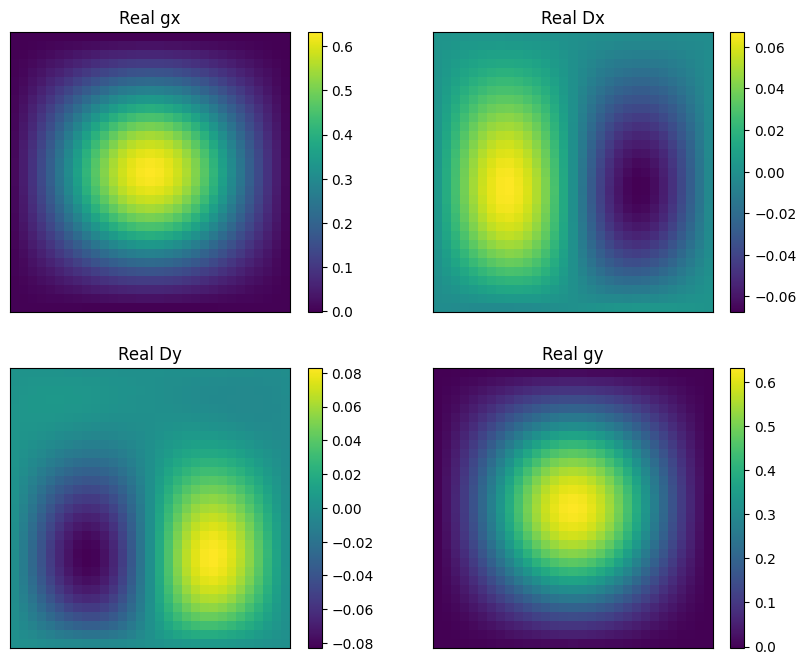

1.0000000928521224 1.0000000931792985
plots/linear_pol_hyperbeam_gains_nside31_t00_f100.000MHz.png


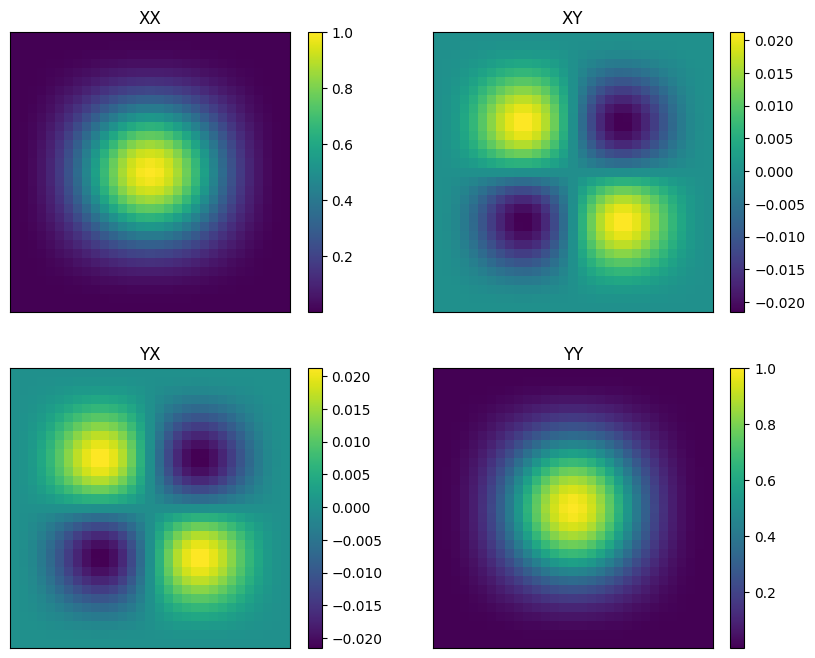

In [10]:

gx = hyper_jones_100_time0[:,0]
Dx = hyper_jones_100_time0[:,1]
Dy = hyper_jones_100_time0[:,2]
gy = hyper_jones_100_time0[:,3]

azs, zas = _, _
plot_jones_square(azs, zas, gx, Dx, Dy, gy, [100e+6],
                  'hyper time 0', tag='hyperbeam',
                      num_times=1, num_freqs=1, nside=NSIDE)

plots/jones_hyperbeam_gains_nside31_t00_f200.000MHz.png


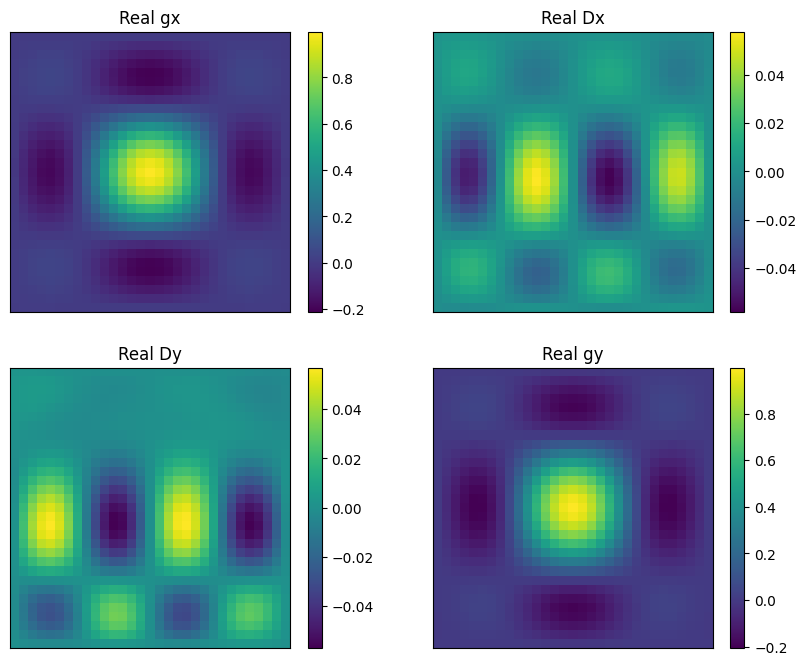

1.0000000616778557 1.0000000652328507
plots/linear_pol_hyperbeam_gains_nside31_t00_f200.000MHz.png


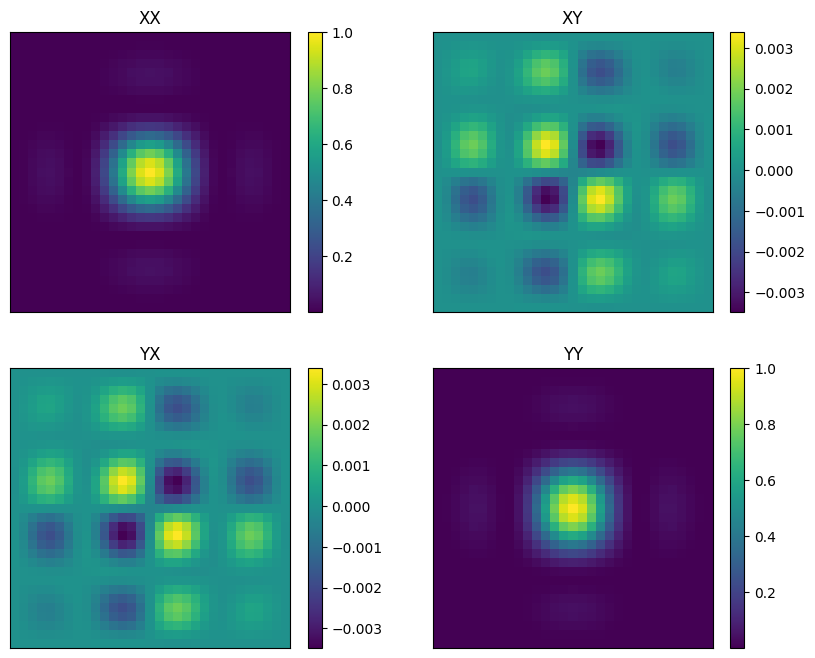

In [11]:
gx = hyper_jones_200_time0[:,0]
Dx = hyper_jones_200_time0[:,1]
Dy = hyper_jones_200_time0[:,2]
gy = hyper_jones_200_time0[:,3]

azs, zas = _, _
plot_jones_square(azs, zas, gx, Dx, Dy, gy, [200e+6],
                  'hyper time 0', tag='hyperbeam',
                      num_times=1, num_freqs=1, nside=NSIDE)

# EveryBeam plots - run after running Ctests
Just test the analytic beam for a single off-zenith pointing. Checks that the delays point things in the correct direction when compared to the FEE beam

plots/jones_everybeam_MWA_gains_nside31_t00_f100.000MHz.png


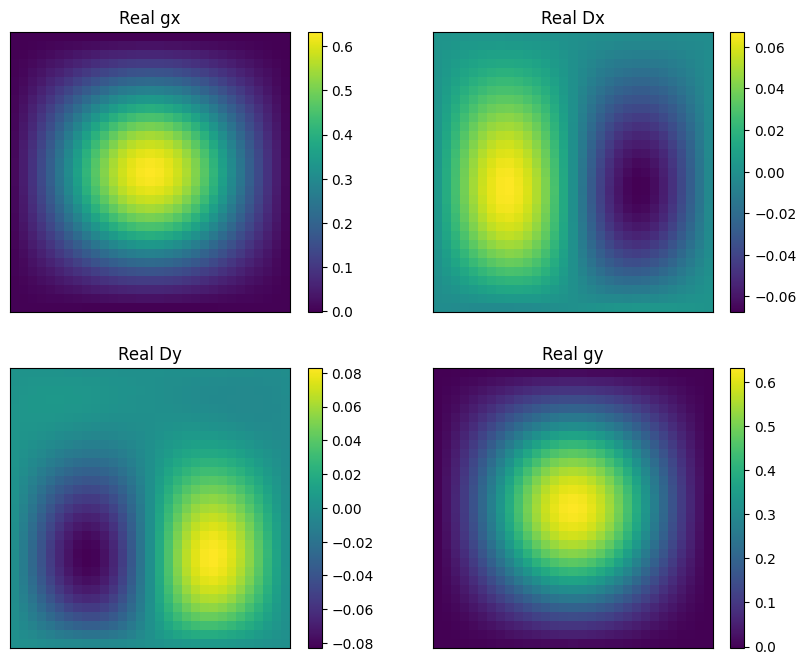

1.0000000482568479 1.0000001378285883
plots/linear_pol_everybeam_MWA_gains_nside31_t00_f100.000MHz.png


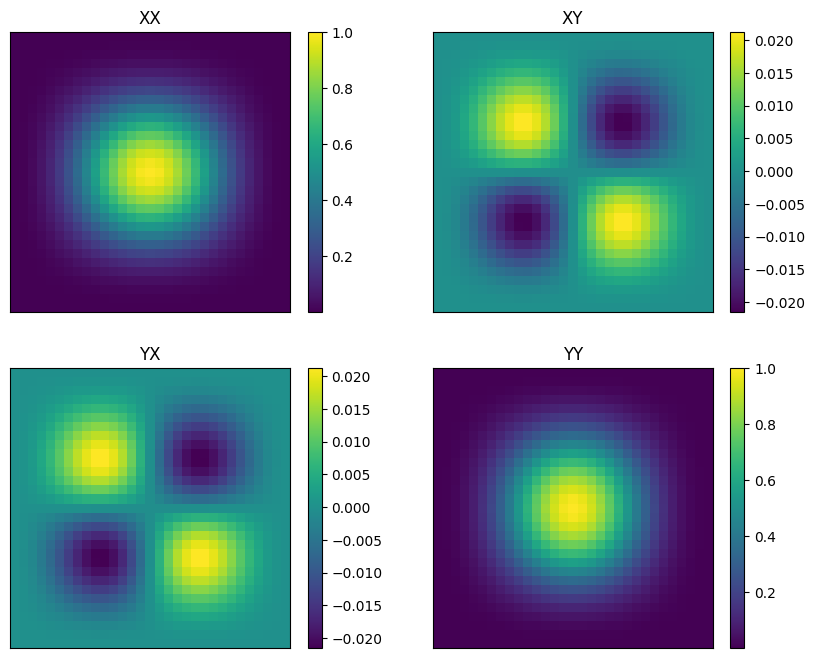

plots/jones_everybeam_MWA_gains_nside31_t00_f150.000MHz.png


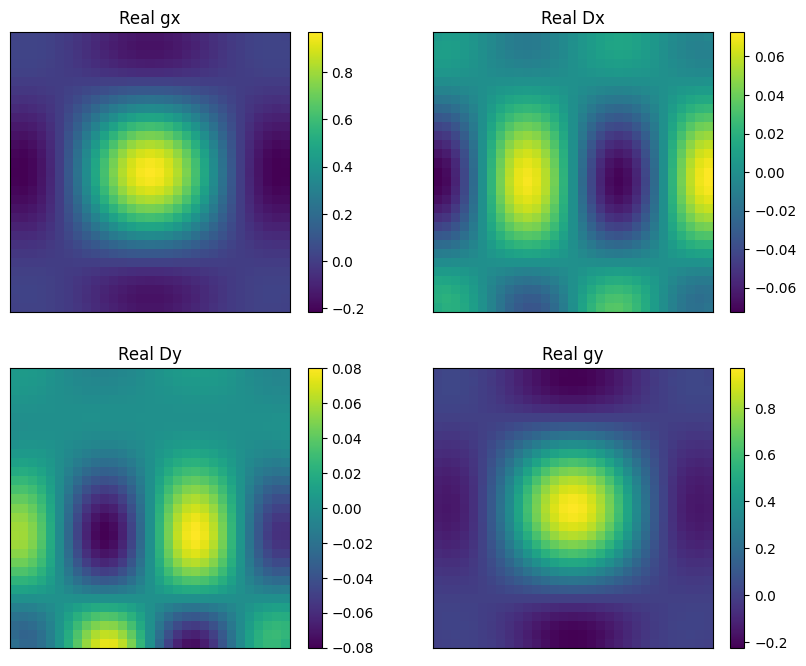

1.0000001205633566 1.000000061122585
plots/linear_pol_everybeam_MWA_gains_nside31_t00_f150.000MHz.png


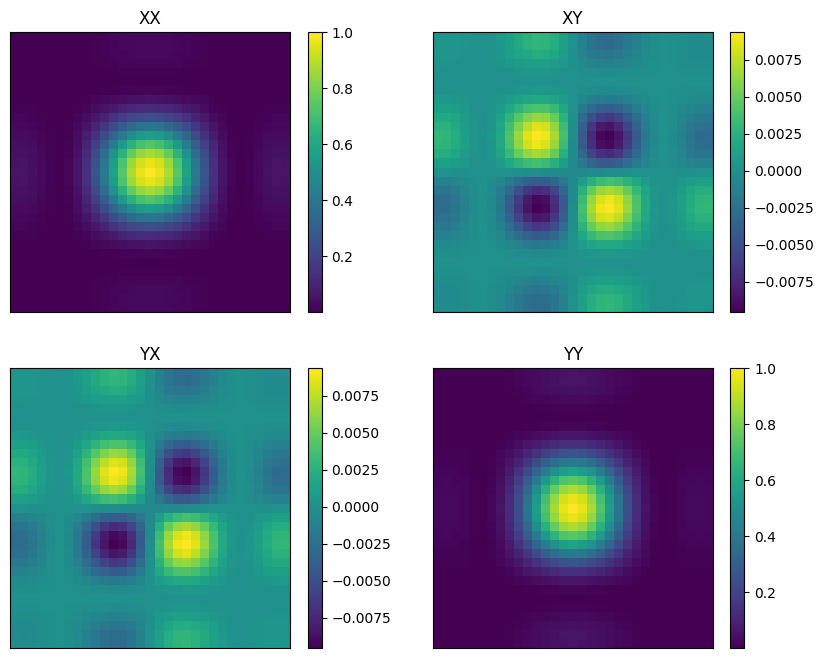

plots/jones_everybeam_MWA_gains_nside31_t00_f200.000MHz.png


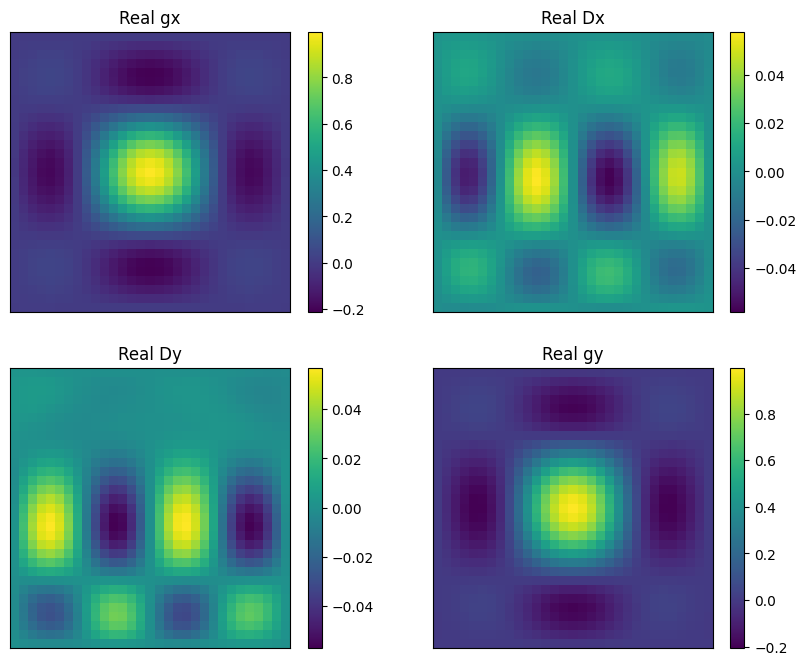

1.0000001035343382 1.0000000319951967
plots/linear_pol_everybeam_MWA_gains_nside31_t00_f200.000MHz.png


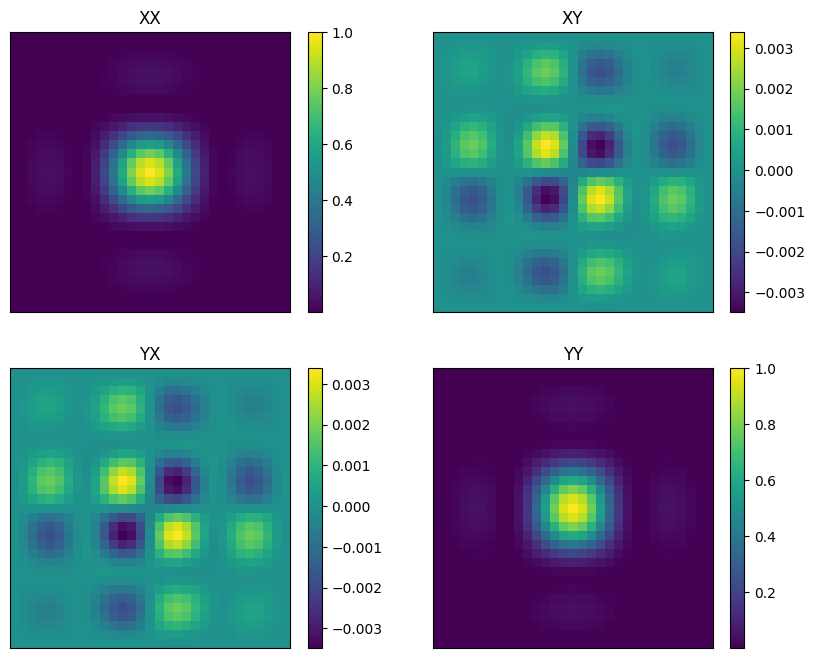

plots/jones_everybeam_MWA_gains_nside31_t01_f100.000MHz.png


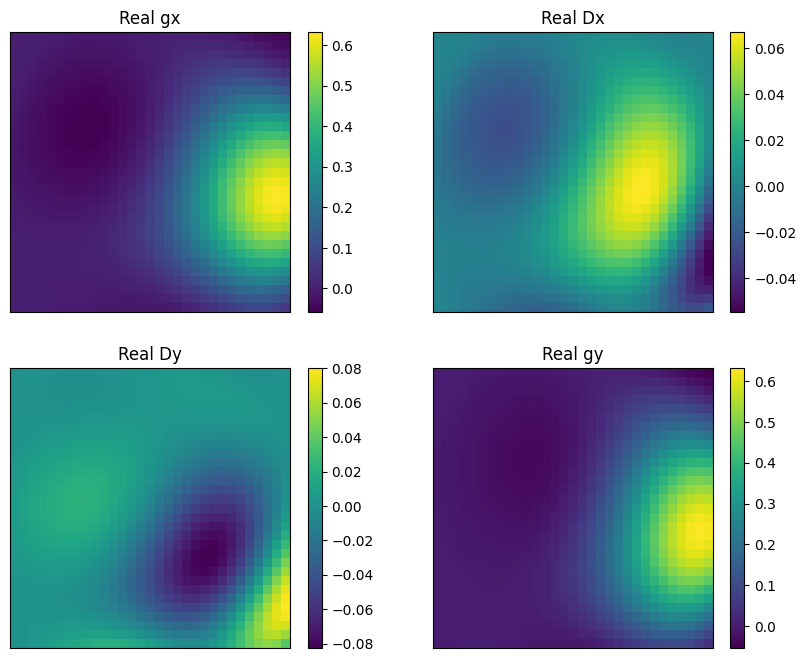

0.9975212953377683 0.9977381449950654
plots/linear_pol_everybeam_MWA_gains_nside31_t01_f100.000MHz.png


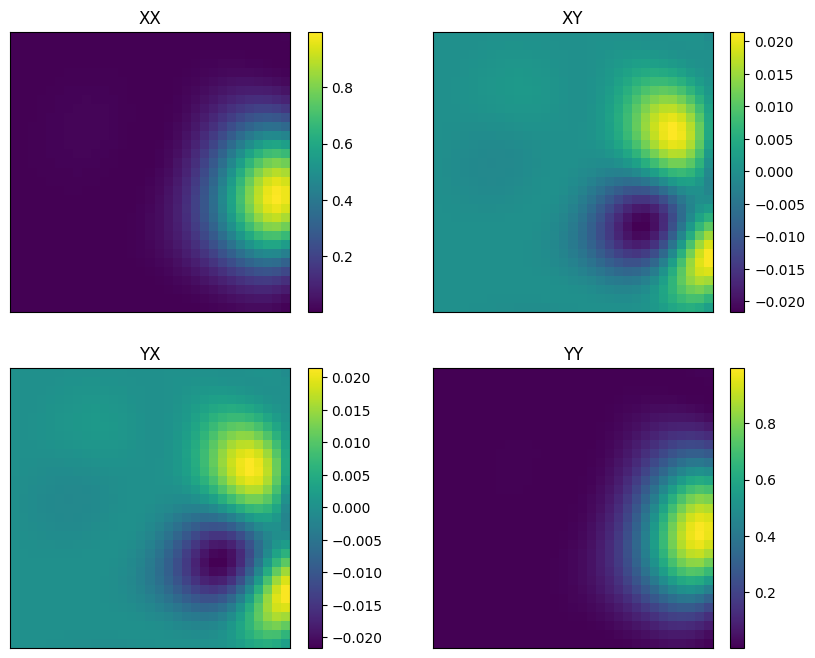

plots/jones_everybeam_MWA_gains_nside31_t01_f150.000MHz.png


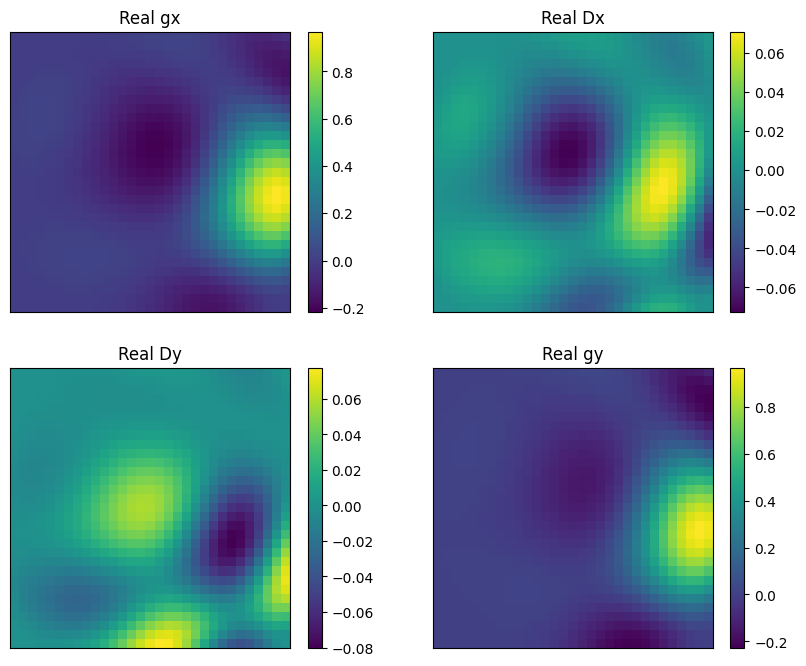

0.9950517598327369 0.9953307245490157
plots/linear_pol_everybeam_MWA_gains_nside31_t01_f150.000MHz.png


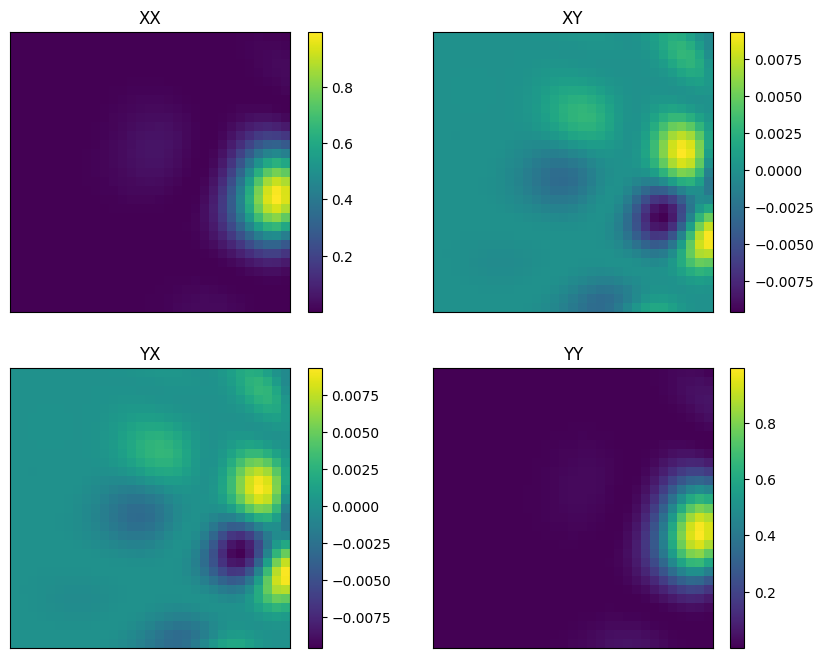

plots/jones_everybeam_MWA_gains_nside31_t01_f200.000MHz.png


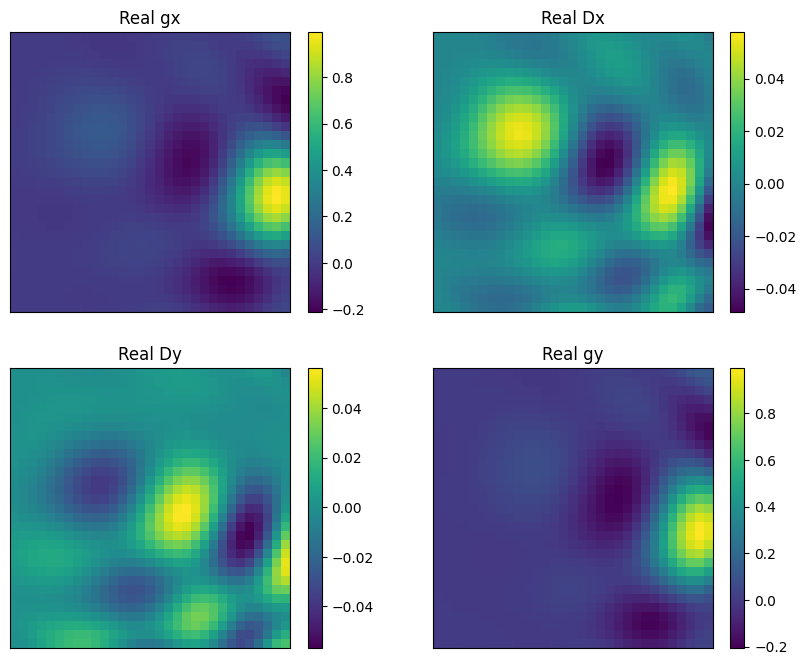

0.9914670371677072 0.9924430222178777
plots/linear_pol_everybeam_MWA_gains_nside31_t01_f200.000MHz.png


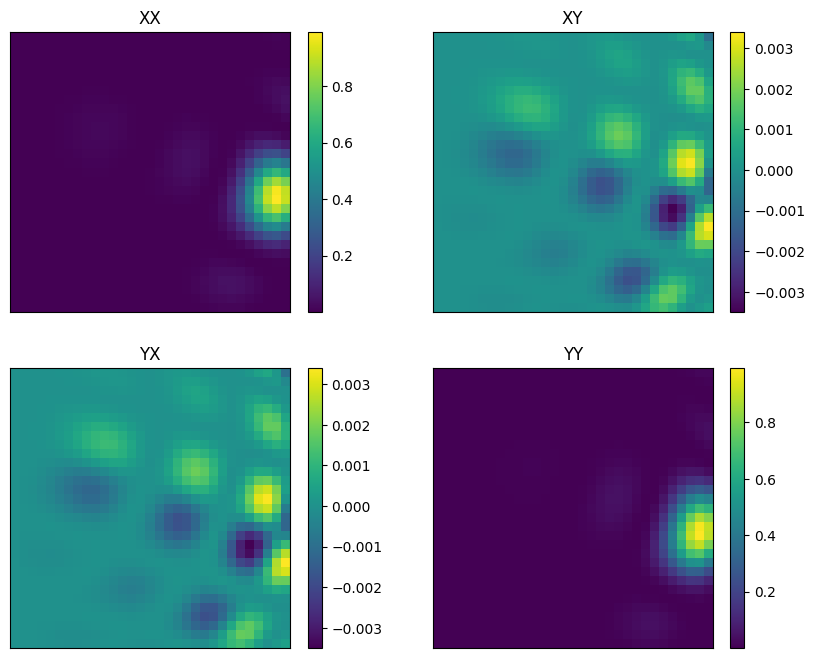

In [15]:
# nside = 

call('mkdir -p plots', shell=True)

plot_freqs = [100e+6, 150e+6, 200e+6]



filename = f'../../../build/cmake_testing/GPU_or_C_code/call_everybeam/mwa_everybeam_values.txt'
azs, zas, gx, Dx, Dy, gy, freqs = load_data(filename)
plot_jones_square(azs, zas, gx, Dx, Dy, gy, plot_freqs, filename,
                      num_times=2, num_freqs=3, nside=NSIDE)